In [39]:
# (Run once) – if your env is missing packages
# !pip install numpy scipy opencv-python scikit-image tqdm matplotlib

import os, sys, math, csv
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


In [40]:
# === EDIT THESE ===
PROJECT_ROOT = Path.cwd()  # keep notebook in the project root
DATA_ROOT = PROJECT_ROOT / "BSDS200"   # folder with clean images (png/jpg/bmp)
OUT_ROOT  = PROJECT_ROOT / "outputs_bp_em"  # where results & CSV will be saved
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Paper-scale defaults
L = 256          # number of labels (try 128 first, then 256 if you want)
SIGMA = 20.0      # AWGN std on uint8 scale (e.g., 15 or 25)
ALPHA0 = 0.005    # prior smoothness init
BP_ITERS = 150     # 60-120 is typical; increase if needed
EM_ITERS = 20     # 10-30 typical
DAMP_RHO = 0.5    # message damping factor
RESIZE_TO = (256, 256)  # downscale for speed/stability (None for native size)
K_NOISY = 1       # number of noisy copies to synthesize for each clean image (1 or 5)

# Reproducibility
SEED = 0
np.random.seed(SEED)


In [41]:
def imread_gray_uint8(path: Path) -> np.ndarray:
    """Read image and return uint8 grayscale (0-255)."""
    arr = cv2.imdecode(np.fromfile(str(path), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if arr is None:
        raise FileNotFoundError(path)
    if arr.ndim == 3:
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
    if RESIZE_TO is not None:
        arr = cv2.resize(arr, RESIZE_TO, interpolation=cv2.INTER_AREA)
    return arr.astype(np.uint8)

def stack_noisy_from_clean(clean_u8: np.ndarray, K=1, sigma=15.0, seed=0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    h, w = clean_u8.shape
    noise = rng.normal(0.0, sigma, size=(K, h, w)).astype(np.float32)
    Y = np.clip(clean_u8[None, ...].astype(np.float32) + noise, 0, 255).astype(np.uint8)
    return Y  # (K,H,W)

def save_u8_png(path: Path, arr_u8: np.ndarray):
    path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imencode(".png", arr_u8)[1].tofile(str(path))


In [42]:
def unary_cost_stack(Yk: np.ndarray, L: int = 256, sigma2: float = 15.0**2) -> np.ndarray:
    """
    Yk: (K,H,W) uint8 or float, values 0..255
    Return psi_i(x) (H,W,L) = (1/(2 sigma^2)) * sum_k (x - y_k)^2
    """
    if Yk.dtype != np.float32:
        Yk = Yk.astype(np.float32)
    K, H, W = Yk.shape
    labels = np.arange(L, dtype=np.float32)  # 0..L-1
    psi = np.zeros((H, W, L), dtype=np.float32)
    for k in range(K):
        y = Yk[k]  # (H,W)
        diff2 = (labels[None, None, :] - y[..., None])**2
        psi += diff2
    psi *= (1.0 / (2.0 * sigma2))
    return psi

def pairwise_kernel(L: int = 256, alpha: float = 0.005) -> np.ndarray:
    xs = np.arange(L, dtype=np.float32)
    d = np.minimum(xs, L - xs)  # circular distance on label ring
    ker = np.exp(-alpha * (d**2))
    s = np.sum(ker)
    if s > 0:
        ker /= s
    return ker.astype(np.float32)

def normalize_messages(m: np.ndarray, eps=1e-32) -> np.ndarray:
    s = np.sum(m, axis=-1, keepdims=True)
    s = np.maximum(s, eps)
    return (m / s).astype(np.float32)


In [43]:
from numpy.fft import rfft, irfft

def _fft_convolve_label(m_in: np.ndarray, ker_fft: np.ndarray) -> np.ndarray:
    L = m_in.shape[-1]
    M = rfft(m_in, axis=-1)
    out = irfft(M * ker_fft, n=L, axis=-1)
    return np.maximum(out.astype(np.float32), 1e-32)

def bp_denoise(psi_cost: np.ndarray, alpha: float, max_bp_iter=80, tol=1e-4, rho=0.5) -> tuple:
    """
    Loopy BP on 4-neighbor grid, label convolutions via FFT.
    psi_cost: (H,W,L) unary costs; alpha: pairwise weight exp(-alpha d^2)
    Returns (beliefs, messages)
    """
    H, W, L = psi_cost.shape
    ker = pairwise_kernel(L=L, alpha=alpha)
    ker_fft = rfft(ker, n=L)

    # init messages uniform
    uni = np.ones((H, W, L), dtype=np.float32) / float(L)
    messages = {d: uni.copy() for d in ['up','down','left','right']}

    def roll(a, sh):
        return np.roll(a, shift=sh, axis=(0,1))

    for t in range(max_bp_iter):
        old = {k: v.copy() for k, v in messages.items()}

        eps = 1e-32
        log_u = -psi_cost.astype(np.float32)
        logM = {d: np.log(np.maximum(messages[d], eps)) for d in ['up','down','left','right']}
        log_prod_all = log_u + logM['up'] + logM['down'] + logM['left'] + logM['right']

        new = {}

        # UP: sender below
        log_sender = log_prod_all - logM['down']
        log_sender = roll(log_sender, (-1, 0))
        log_sender -= log_sender.max(axis=-1, keepdims=True)
        sender = np.exp(log_sender)
        new['up'] = normalize_messages(_fft_convolve_label(sender, ker_fft))

        # DOWN: sender above
        log_sender = log_prod_all - logM['up']
        log_sender = roll(log_sender, (1, 0))
        log_sender -= log_sender.max(axis=-1, keepdims=True)
        sender = np.exp(log_sender)
        new['down'] = normalize_messages(_fft_convolve_label(sender, ker_fft))

        # LEFT: sender right
        log_sender = log_prod_all - logM['right']
        log_sender = roll(log_sender, (0, -1))
        log_sender -= log_sender.max(axis=-1, keepdims=True)
        sender = np.exp(log_sender)
        new['left'] = normalize_messages(_fft_convolve_label(sender, ker_fft))

        # RIGHT: sender left
        log_sender = log_prod_all - logM['left']
        log_sender = roll(log_sender, (0, 1))
        log_sender -= log_sender.max(axis=-1, keepdims=True)
        sender = np.exp(log_sender)
        new['right'] = normalize_messages(_fft_convolve_label(sender, ker_fft))

        # damping
        for d in ['up','down','left','right']:
            messages[d] = (1.0 - rho) * old[d] + rho * new[d]

        # convergence check (L1 avg)
        diff = 0.0
        for d in ['up','down','left','right']:
            diff += np.mean(np.abs(messages[d] - old[d]))
        if diff < tol:
            break

    # Compute beliefs robustly in log-domain, normalize
    eps = 1e-32
    log_b = -psi_cost.astype(np.float32)
    for d in ['up','down','left','right']:
        log_b += np.log(np.maximum(messages[d], eps))
    log_b -= np.max(log_b, axis=-1, keepdims=True)
    b = np.exp(log_b)
    b = b / np.maximum(b.sum(axis=-1, keepdims=True), eps)
    return b.astype(np.float32), messages


In [44]:
def em_update(Yk: np.ndarray, beliefs: np.ndarray, messages: dict,
              sigma2_curr: float, alpha_curr: float,
              max_em_iter=20, tol=1e-4) -> tuple:
    """
    Simple EM: update sigma^2 by expected data term; update alpha by 1D search
    matching expected quadratic label difference.
    """
    if Yk.dtype != np.float32:
        Yk = Yk.astype(np.float32)
    K, H, W = Yk.shape
    L = beliefs.shape[-1]
    labels = np.arange(L, dtype=np.float32)

    sigma2 = float(sigma2_curr)
    alpha = float(alpha_curr)

    xs = np.arange(L, dtype=np.float32)
    d = np.minimum(xs, L - xs)
    phi = d**2

    for _ in range(max_em_iter):
        # E[ (x - y)^2 ] with beliefs
        psi_exp = 0.0
        for k in range(K):
            y = Yk[k][..., None]
            diff2 = (labels[None, None, :] - y)**2
            psi_exp += np.sum(diff2 * beliefs, axis=-1)  # (H,W)
        sigma2_new = float(psi_exp.sum() / (H * W * K))
        sigma2_new = max(sigma2_new, 1e-6)

        # estimate posterior expected phi via messages (approx):
        # use beliefs as proxy for pairwise marginals’ contrast
        # compute per-pixel label variance as a surrogate and match to prior
        mu = np.sum(beliefs * labels[None, None, :], axis=-1)  # (H,W)
        var = np.sum(beliefs * (labels[None, None, :] - mu[..., None])**2, axis=-1)
        target = float(np.mean(var))  # proxy for average squared diff

        def expected_phi_prior(a):
            ker = np.exp(-a * phi)
            ker /= np.maximum(ker.sum(), 1e-12)
            return float((phi * ker).sum())

        lo, hi = 0.0, max(2.0 * max(alpha, 1e-6), 1e-6)
        for _it in range(40):
            mid = 0.5 * (lo + hi)
            val = expected_phi_prior(mid)
            if val > target:
                lo = mid
            else:
                hi = mid
        alpha_new = 0.5 * (lo + hi)
        alpha_new = max(alpha_new, 1e-8)

        delta = abs(alpha_new - alpha) + abs(sigma2_new - sigma2) / max(1.0, sigma2)
        alpha, sigma2 = alpha_new, sigma2_new
        if delta < tol:
            break

    return sigma2, alpha


beliefs avg sum: 1.0
x_map range: 23 201


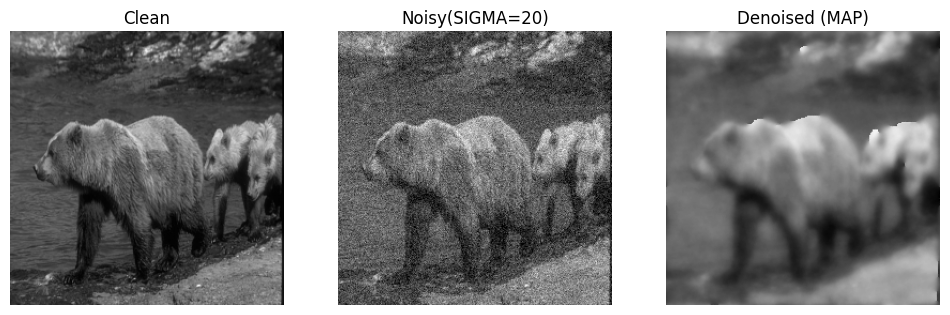

In [45]:
# pick one clean image
clean_list = sorted([p for p in DATA_ROOT.iterdir() if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}])
assert len(clean_list) > 0, "No images found in BSDS200 folder!"
clean = imread_gray_uint8(clean_list[0])

# synthesize noisy copies
Yk = stack_noisy_from_clean(clean, K=K_NOISY, sigma=SIGMA, seed=SEED)
sigma2 = SIGMA**2
alpha = ALPHA0

# build unary
psi = unary_cost_stack(Yk, L=L, sigma2=sigma2)

# --- BP (fixed params)
beliefs, messages = bp_denoise(psi, alpha=alpha, max_bp_iter=BP_ITERS, tol=1e-4, rho=DAMP_RHO)

# --- EM (optional; run after BP is stable)
sigma2, alpha = em_update(Yk, beliefs, messages, sigma2_curr=sigma2, alpha_curr=alpha,
                          max_em_iter=EM_ITERS, tol=1e-4)

# rebuild unary with updated sigma2 and run BP again
psi = unary_cost_stack(Yk, L=L, sigma2=sigma2)
beliefs, messages = bp_denoise(psi, alpha=alpha, max_bp_iter=BP_ITERS, tol=1e-4, rho=DAMP_RHO)

# MAP in log-domain (robust)
log_b = -psi.astype(np.float32)
for d in ['up','down','left','right']:
    log_b += np.log(np.maximum(messages[d], 1e-32))
log_b -= np.max(log_b, axis=-1, keepdims=True)
x_map = np.argmax(log_b, axis=-1).astype(np.uint8)

print("beliefs avg sum:", float(np.mean(beliefs.sum(axis=-1))))  # ~1.0
print("x_map range:", int(x_map.min()), int(x_map.max()))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Clean"); plt.imshow(clean, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title(f"Noisy(SIGMA={int(SIGMA)})"); plt.imshow(Yk[0], cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Denoised (MAP)"); plt.imshow(x_map, cmap='gray'); plt.axis('off')
plt.show()
